In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()


In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
block_size = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) 
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [5]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embed = 10 # embedding dimension
n_hidden = 200 # hidden layer size
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((len(stoi), n_embed), generator=g)
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, len(stoi)), generator=g)
b2 = torch.randn(len(stoi), generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb] # batch_size, context_size, embedding_size
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1 # batch_size, n_hidden
    h = torch.tanh(hpreact) # batch_size, n_hidden
    logits = h @ W2 + b2 # batch_size, num_classes
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()


    # Update
    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())



      0/ 200000: 27.8817
  10000/ 200000: 2.8902
  20000/ 200000: 2.5560
  30000/ 200000: 2.8463
  40000/ 200000: 2.0837
  50000/ 200000: 2.7537
  60000/ 200000: 2.3159
  70000/ 200000: 2.0292
  80000/ 200000: 2.3787
  90000/ 200000: 2.2568
 100000/ 200000: 2.1105
 110000/ 200000: 2.3249
 120000/ 200000: 1.8858
 130000/ 200000: 2.4050
 140000/ 200000: 2.2072
 150000/ 200000: 2.1588
 160000/ 200000: 2.0546
 170000/ 200000: 1.7809
 180000/ 200000: 1.9943
 190000/ 200000: 1.8212


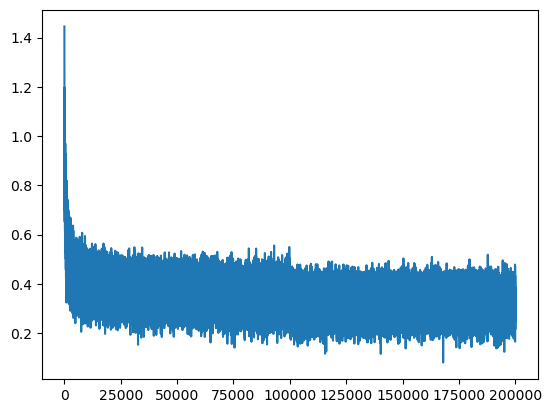

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # batch_size, context_size, embedding_size
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1) # batch_size, n_hidden
    logits = h @ W2 + b2 # batch_size, num_classes
    loss = F.cross_entropy(logits, y)
    print(f"{split} loss: {loss.item():.4f}")
split_loss('train')
split_loss('val')

train loss: 2.1246
val loss: 2.1656


In [10]:
# sample from the model
context_size = 3
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * context_size
    while True:
        emb = C[torch.tensor([context])] # 1, context_size, embedding_size
        embcat = emb.view(1, -1) 
        h = torch.tanh(embcat @ W1 + b1) # 1, n_hidden
        logits = h @ W2 + b2 # 1, num_classes
        probs = F.softmax(logits, dim=1) # 1, num_classes
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(itos[ix])
    print(''.join(out)) 

carlah
amelle
khi
mili
taty
skanden
jazhuel
den
art
kaeli
nellara
chaiir
kaleigh
ham
jorn
quint
salin
alianni
wazthoniearysi
jaxeusinsleen
